In [24]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin

code_id = '0841 - Prelap Neural Activity'
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

def get_data(trace):
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    route_trajs = []
    lap_trajs = []
    
    for i in tqdm(range(beg_idx.shape[0])):
        if routes[i] == 0:
            continue
        
        if routes[i-1] != routes[i]:
            continue
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]-10000) & (trace['ms_time'] <= beg_time[i])
        )[0]
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
    
    return np.concatenate(neural_trajs, axis=1), np.concatenate(pos_trajs), np.concatenate(route_trajs), np.concatenate(lap_trajs)

with open(f2['Trace File'][34], 'rb') as handle:
    trace = pickle.load(handle)
    
neural_trajs, pos_trajs, route_trajs, lap_trajs = get_data(trace)

        E:\Data\FinalResults\Dsp\0841 - Prelap Neural Activity is already existed!


  0%|          | 0/130 [00:00<?, ?it/s]C:\Users\12454\AppData\Local\Temp\ipykernel_5952\1971628276.py:30: RuntimeWarning: invalid value encountered in cast
  spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
100%|██████████| 130/130 [00:00<00:00, 432.87it/s]


In [21]:
def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])

  0%|          | 0/130 [00:00<?, ?it/s]C:\Users\12454\AppData\Local\Temp\ipykernel_5952\1971628276.py:30: RuntimeWarning: invalid value encountered in cast
  spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
100%|██████████| 130/130 [00:00<00:00, 283.85it/s]


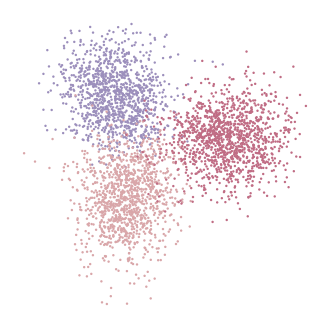

ValueError: The 'color' keyword argument must have one color per dataset, but 2 datasets and 1 colors were provided

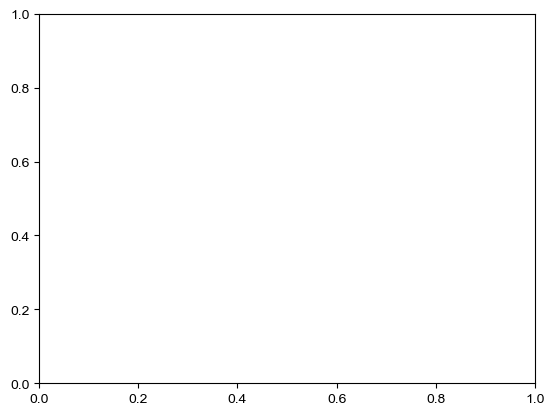

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from umap.umap_ import UMAP
from sklearn.decomposition import PCA

def plot(trace):
    neural_traj, pos_traj, route_traj, lap_traj = get_data(trace)

    idx = np.where(np.isin(route_traj, [2, 3, 6]))[0]
    neural_traj = neural_traj[:, idx]
    pos_traj = pos_traj[idx]
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]

    corr_trajs = trace['lapwise_corr'][lap_traj]
    map_trajs = np.where(corr_trajs < 0.095, 1, 2)
    
    pcam = PCA(n_components=300)
    reduced_data = pcam.fit_transform(neural_traj.T)
    model = LDA(n_components=2)
    reduced_data = model.fit_transform(reduced_data, route_traj)
    PC1, PC2 = reduced_data[:, 0], reduced_data[:, 1]
    route_colors = DSPPaletteRGBA[route_traj.astype(np.int64), :]
    
    fig = plt.figure(figsize=(4, 4))
    ax = Clear_Axes(plt.axes())
    ax.scatter( 
        PC1, PC2,
        color=route_colors,
        s=3,
        linewidth = 0
    )
    
    plt.show()
    
    plt.hist(reduced_data[map_trajs == 1], color = '#A4C096', alpha=0.5, range=(-6, 6), bins=48, density=True)
    plt.hist(reduced_data[map_trajs == 2], color = '#333766', alpha=0.5, range=(-6, 6), bins=48, density=True)
plot(trace)